In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

from datetime import datetime, timedelta

import operator

import mpmath as mp
from importlib import reload

from utils import utils, net_lstm, net_lstm_w2v
from tqdm import tqdm
import random
sns.set(style="whitegrid")
import umap

torch.manual_seed(1)

In [2]:
reload(utils)
# Getting a list of valid candidates given properties
pep_info = pd.read_pickle("data_inf.pkl")

pep_600 = list(pep_info[(pep_info["length"]>1000)].index)
good_peps = np.loadtxt('good_peps.txt',dtype=int)

# Defining users we are working with
train_peps = good_peps[good_peps<=700]
train_peps = np.array(list(set(train_peps).intersection(pep_600)))

train_peps_all = good_peps
train_peps_all = np.array(list(set(train_peps_all).intersection(pep_600)))

train_peps_vali = good_peps[good_peps>700]
train_peps_vali = np.array(list(set(train_peps_vali).intersection(pep_600)))

In [3]:
# Loading in the network and previously trained weights
path = "Network/network_epoch_0.338_Feb-23-2020"

reload(net_lstm_w2v)
net_umap = net_lstm_w2v.Brain()
net_umap.create_model()
net_umap.model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Embedding of type locations

In [4]:
# Computing the umap transformation down onto 2 dimensions

reducer = umap.UMAP(n_neighbors= 15, n_components = 2)
tmp = net_umap.model.embeddings_type.weight.cpu().detach().numpy()
type_600 = np.array([p*20 + ii for p in train_peps for ii in range(20)])
embedding = reducer.fit_transform(tmp[type_600])

D:\Anaconda3\envs\py36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\Anaconda3\envs\py36\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
D:\Anaconda3\envs\py36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\Anaconda3\envs\py36\lib\site-packages\umap\rp_tree.py", line 1

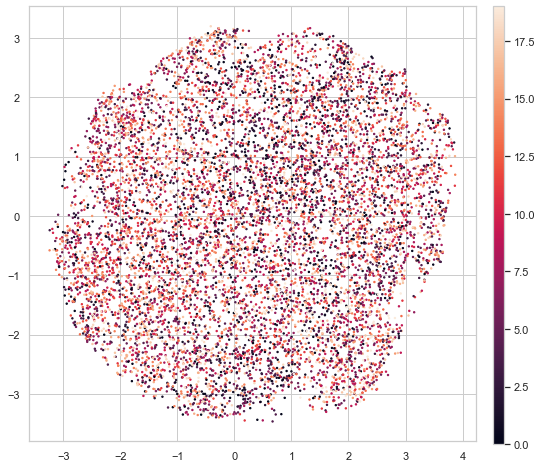

In [10]:
f, ax = plt.subplots(1,1,figsize=(8, 8))
cmap = sns.cubehelix_palette(as_cmap=True)

points = ax.scatter(x=embedding[:,0], y=embedding[:,1], c=type_600%20,s=2)
ax.title.set_size(15)

cb_ax = f.add_axes([0.93, 0.12, 0.02, 0.76])
f.colorbar(points,cax=cb_ax);

f.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\network_embedding.png', format='png')
plt.show()

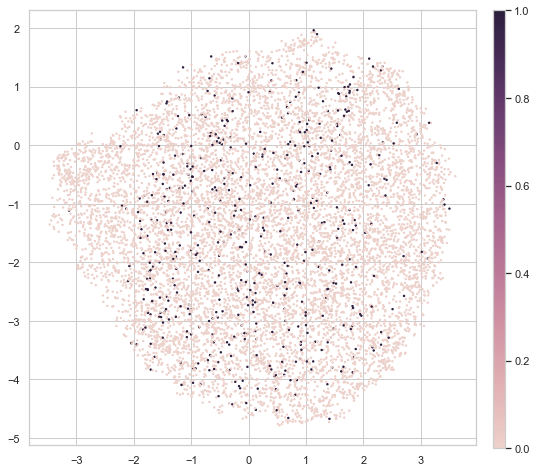

In [6]:
f, ax = plt.subplots(1,1,figsize=(8, 8))
cmap = sns.cubehelix_palette(as_cmap=True)

points = ax.scatter(x=embedding[:,0], y=embedding[:,1], c=(type_600%20==2),s=2,cmap=cmap)

cb_ax = f.add_axes([0.93, 0.12, 0.02, 0.76])
f.colorbar(points,cax=cb_ax);

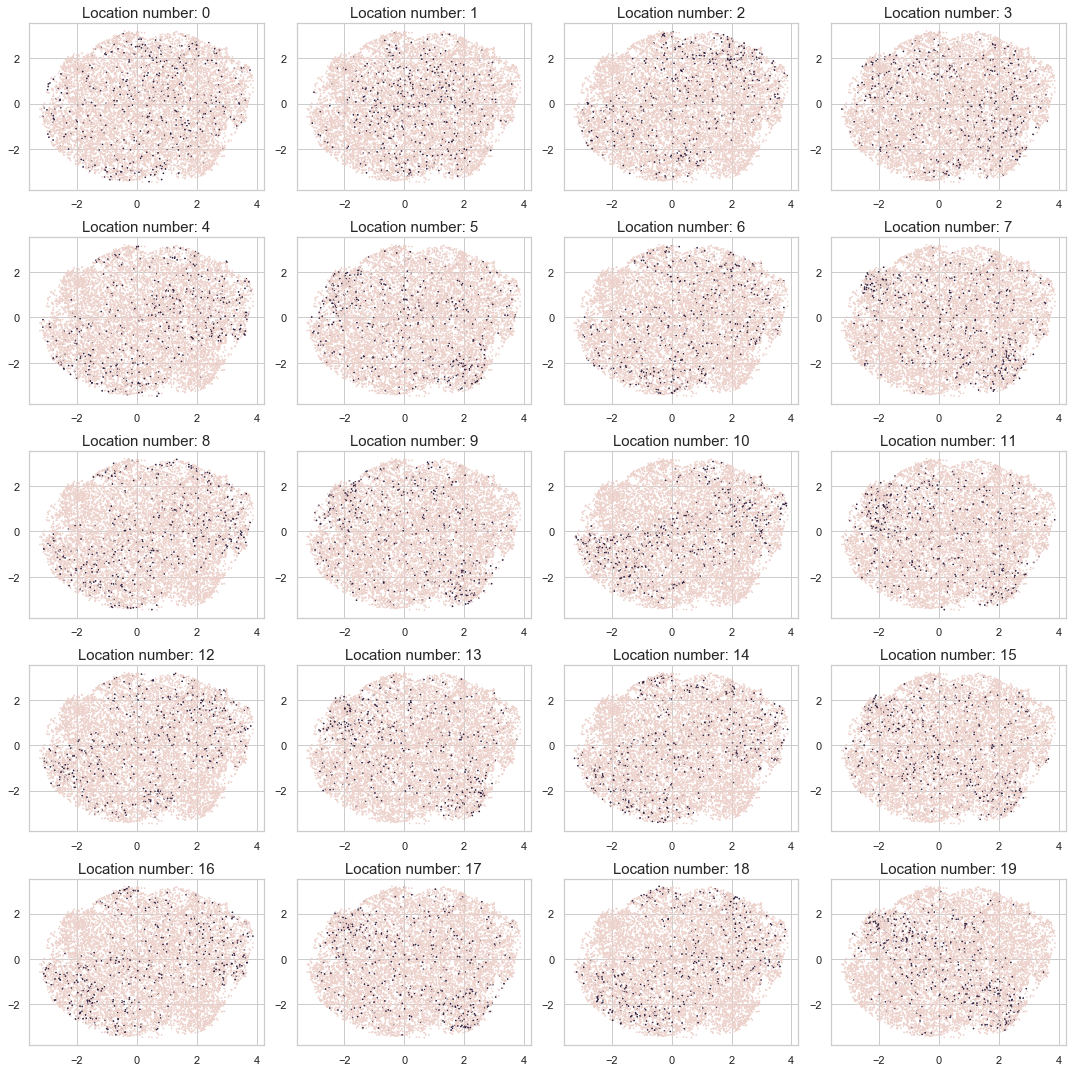

In [9]:
nrow = 5
ncol = 4
f, ax = plt.subplots(nrow,ncol,figsize=(15, 15))
cmap = sns.cubehelix_palette(as_cmap=True)
for i in range(20):
    points = ax[i//ncol,i%ncol].scatter(x=embedding[:,0], y=embedding[:,1], c=(type_600%20==i),s=0.5,cmap=cmap)
    ax[i//ncol,i%ncol].set_title(f'Location number: {i}')
    ax[i//ncol,i%ncol].title.set_size(15)
#cb_ax = f.add_axes([0.93, 0.12, 0.02, 0.76])
#f.colorbar(points,cax=cb_ax);
plt.tight_layout()
f.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\network_embedding_individual.png', format='png')


## Embedding of users

In [32]:
reducer = umap.UMAP(n_neighbors= 15, n_components = 2)
tmp = net_umap.model.embeddings_pep.weight.cpu().detach().numpy()
type_600 = np.array(train_peps)
embedding = reducer.fit_transform(tmp[type_600])

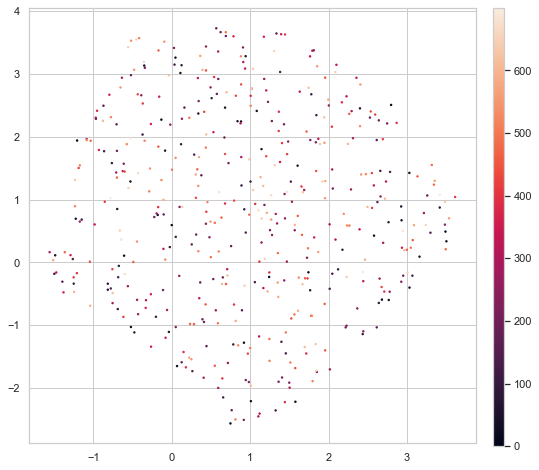

In [33]:
f, ax = plt.subplots(1,1,figsize=(8, 8))
cmap = sns.cubehelix_palette(as_cmap=True)

points = ax.scatter(x=embedding[:,0], y=embedding[:,1], c=type_600,s=2)

cb_ax = f.add_axes([0.93, 0.12, 0.02, 0.76])
f.colorbar(points,cax=cb_ax);

#f.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\network_embedding.eps', format='eps', dpi=1200)
plt.show()

## Embedding day

In [35]:
reducer = umap.UMAP(n_neighbors= 2, n_components = 2)
tmp = net_umap.model.embeddings_day.weight.cpu().detach().numpy()
type_600 = np.array(train_peps)
embedding = reducer.fit_transform(tmp[range(7)])

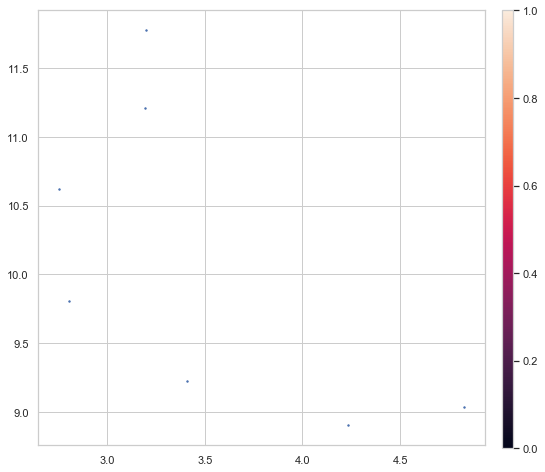

In [41]:
f, ax = plt.subplots(1,1,figsize=(8, 8))
cmap = sns.cubehelix_palette(as_cmap=True)

points = ax.scatter(x=embedding[:,0], y=embedding[:,1],s=2)

cb_ax = f.add_axes([0.93, 0.12, 0.02, 0.76])
f.colorbar(points,cax=cb_ax);

#f.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\network_embedding.eps', format='eps', dpi=1200)
plt.show()

In [40]:
embedding[:,1]

array([ 8.904918, 10.620532,  9.810363,  9.226246, 11.772231, 11.211974,
        9.037451], dtype=float32)

In [39]:
embedding[:,0]

array([4.23336  , 2.7542794, 2.8060286, 3.4073594, 3.1981401, 3.1931407,
       4.825685 ], dtype=float32)

# Embedding rank

In [9]:
reducer = umap.UMAP(n_neighbors= 15, n_components = 2)
tmp = net_umap.model.embeddings_rank.weight.cpu().detach().numpy()
type_600 = np.array(range(20))
embedding = reducer.fit_transform(tmp[type_600])

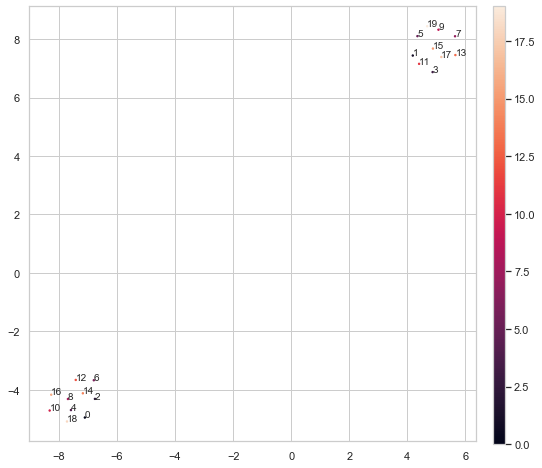

In [10]:
f, ax = plt.subplots(1,1,figsize=(8, 8))
cmap = sns.cubehelix_palette(as_cmap=True)

points = ax.scatter(x=embedding[:,0], y=embedding[:,1],c=type_600,s=2)

cb_ax = f.add_axes([0.93, 0.12, 0.02, 0.76])
f.colorbar(points,cax=cb_ax);
for i, txt in enumerate(range(20)):
    ax.annotate(txt, (embedding[:,0][i], embedding[:,1][i]))

#f.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\network_embedding.eps', format='eps', dpi=1200)
plt.show()